# Today you are a Machine Learning Engineer at Walmart!
For your latest assignemt, your manager has asked your team to work alongside the Data Engineering team to design an optimal Machine Learning pipeline for Automated Inventory, i.e. predicting purchases per customer accurately. The Data Engineering team has used Trifacta to clean some online shopping data gathered from the servers over the last few months. They also tell you that consumer research has found 5 behavioral categories of online shopping customers.

You are expected to report back the following to your manager:
1. The "Best Model" selection pipeline for incoming data.
2. Identified 5 customer bahavior clusters.
3. Predictive nature of each Customer Behavior cluster.
4. Inferences regarding each Customer Behavior Cluster.

### This assignment is based on the work in: https://arxiv.org/pdf/2102.01625.pdf
Additional Code and explanations available at: https://github.com/sohiniroych/Volvo-DataX/blob/master/User%20Journey%20Modeling/Cosmetics_Journey.ipynb

# Load the Data
In this assignment, we will read client data that has been pre-processed (using Trifacta), and stored in an S3 bucket name "mlops-ecommerce". Working off the S3 bucket directly allows you freedom to work from any workstation and also to maintain the integrity of the data sensitivity (no need to download on system).

In [1]:
## Start with loading the Libraries and loading the data
import boto3
import io
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import sagemaker
import sagemaker.amazon.common as smac
from sagemaker import get_execution_role
from sagemaker.predictor import csv_serializer, json_deserializer

from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

## For this work, the data from "mlops-ecommerce" bucket will be accessed using boto3! The next step will take about 5-10 mins to load since the data is large!

In [2]:
role = get_execution_role()
bucket='mlops-week-1'
data_key = 'Cosmetics_Journey_25.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

raw_data=pd.read_csv(data_location)

In [2]:
## Importing required Libraries
import os
import numpy as np
import pandas as pd
import seaborn as sb

In [3]:
path = '/Users/alejandro.robles/PycharmProjects/fbai-mlops-assignments/data/Cosmetics_Journey_25.csv'
raw_data = pd.read_csv(path)

In [4]:
#Write code to print the shape of raw_data
raw_data.shape
###############################

(1100000, 36)

In [5]:
# Write code to print first few rows of raw_data
raw_data.head()
#############################

,user_id,product_id,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,NumRemove,...,Nov,Dec,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Noon,Purchase
0,557218959,5887255,4,1,17.0,2.52,2.52,3,1,0,...,0,0,0,1,0,0,0,0,0,0
1,466018870,5830550,2,2,429.0,1.73,1.73,0,2,0,...,0,0,0,0,0,1,0,0,0,0
2,481499606,5803696,3,2,2817143.0,14.29,14.29,1,0,2,...,0,0,0,0,0,0,1,0,0,0
3,549903361,5881937,1,1,0.0,17.46,17.46,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4,536405450,5736504,1,1,0.0,20.63,20.63,1,0,0,...,0,1,0,0,0,1,0,0,0,0


In [6]:
raw_data.columns

Index(['user_id', 'product_id', 'NumOfEventsInJourney', 'NumSessions',
       'interactionTime', 'maxPrice', 'minPrice', 'NumCart', 'NumView',
       'NumRemove', 'InsessionCart', 'InsessionView', 'InsessionRemove',
       'Weekend', 'Fr', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', '2019',
       '2020', 'Jan', 'Feb', 'Oct', 'Nov', 'Dec', 'Afternoon', 'Dawn',
       'EarlyMorning', 'Evening', 'Morning', 'Night', 'Noon', 'Purchase'],
      dtype='object')

### So you see the Data Engineering team has sent you 1.1M records corresponding to users and their interations with products. Notice two things:
1. All features are numeric (so one-hot-encoding has been done).
2. Last column depicts if the user-product interation resulted in a purchase or not.
Such kind of data is referred to as "User Journeys". This work is based on the recent paper: https://arxiv.org/pdf/2102.01625.pdf

# Task 1: Perform Exploratory Data Analysis (EDA) to find features that are important. 
You can choose any one of the two methods given below OR Run both as well.
```
Method 1: RandomForestClassifier for feature importance https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html that uses Entropy based measure called GINI Index to rank features of importance

Method 2: Fisher scoring method using the sklearn feature_selection library https://scikit-learn.org/stable/modules/feature_selection.html
```

Observe some differences in the ranked mathods!

In [1]:
#Load Libraries for Data splitting and normalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import sklearn.feature_selection as fs
import seaborn as sn

In [7]:
#Write code to extract the last column (Purchase) as label YData.
#Write code to extract all remaining rows OTHER THAN user_id and product_id as features XData 

# feauture_cols = raw_data.drop(['user_id', 'product_id', 'Purchase'], axis=1)
# # # feauture_cols
XData = raw_data.drop(['user_id', 'product_id', 'Purchase'], axis=1)
YData = raw_data['Purchase']
#####################################################################################

In [8]:
YData

0          0
1          0
2          0
3          0
4          0
          ..
1099995    0
1099996    0
1099997    0
1099998    0
1099999    0
Name: Purchase, Length: 1100000, dtype: int64

For splitting the data to train/test use the command https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [9]:
# Use the train_test_split function to split the data (XData,YData) into 80/20 split, set random state=42,
# and stratify sampling based on YData (to ensure similar distribution of samples in train and test splits)

# X_train, X_test, y_train, y_test = train_test_split(#Enter parameters here)
X_train, X_test, y_train, y_test = train_test_split(XData, YData, test_size=0.2, random_state=42)
    
    ######################################################################

In [10]:
y_train.value_counts() / y_train.shape[0]

0    0.879768
1    0.120232
Name: Purchase, dtype: float64

In [11]:
y_test

255968     0
780983     0
214662     0
339422     0
634690     0
          ..
71380      0
1004677    0
256333     0
90189      0
1001658    1
Name: Purchase, Length: 220000, dtype: int64

In [12]:
y_test.value_counts() / y_test.shape[0]

0    0.879109
1    0.120891
Name: Purchase, dtype: float64

In [13]:
X_train.head()

,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,NumRemove,InsessionCart,InsessionView,...,Oct,Nov,Dec,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Noon
983041,1,1,0.0,10.95,10.95,0,1,0,2,20,...,1,0,0,0,0,1,0,0,0,0
726704,1,1,0.0,14.75,14.75,0,1,0,5,20,...,0,1,0,0,0,1,0,0,0,0
534674,1,1,0.0,5.76,5.76,0,1,0,9,17,...,0,0,0,0,0,0,1,0,0,0
1087353,1,1,0.0,24.44,24.44,0,1,0,1,3,...,1,0,0,0,0,0,0,1,0,0
2237,1,1,0.0,1.73,1.73,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [14]:
# Next scale all the features in range [0,1] 
MMscaler = MinMaxScaler()
X_train = MMscaler.fit_transform(X_train)
X_test = MMscaler.transform(X_test)

In [15]:
# Method 1: Feature ranking with Random Forest
sel = SelectFromModel(RandomForestClassifier(n_estimators = 10))

In [16]:
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(n_estimators=10))

In [17]:
selected_feat= XData.columns[(sel.get_support())]

In [18]:
importances = sel.estimator_.feature_importances_
importances

array([0.13655   , 0.02685925, 0.10841447, 0.02381289, 0.0210122 ,
       0.11561928, 0.09207703, 0.29230383, 0.04364964, 0.03016291,
       0.06622408, 0.        , 0.00235467, 0.00237524, 0.00219249,
       0.00217008, 0.00246832, 0.00234733, 0.00230291, 0.00155689,
       0.00145943, 0.00177695, 0.00198705, 0.00176022, 0.00180781,
       0.0018588 , 0.00272729, 0.00163303, 0.00233662, 0.00256634,
       0.0023979 , 0.00166588, 0.00156918])

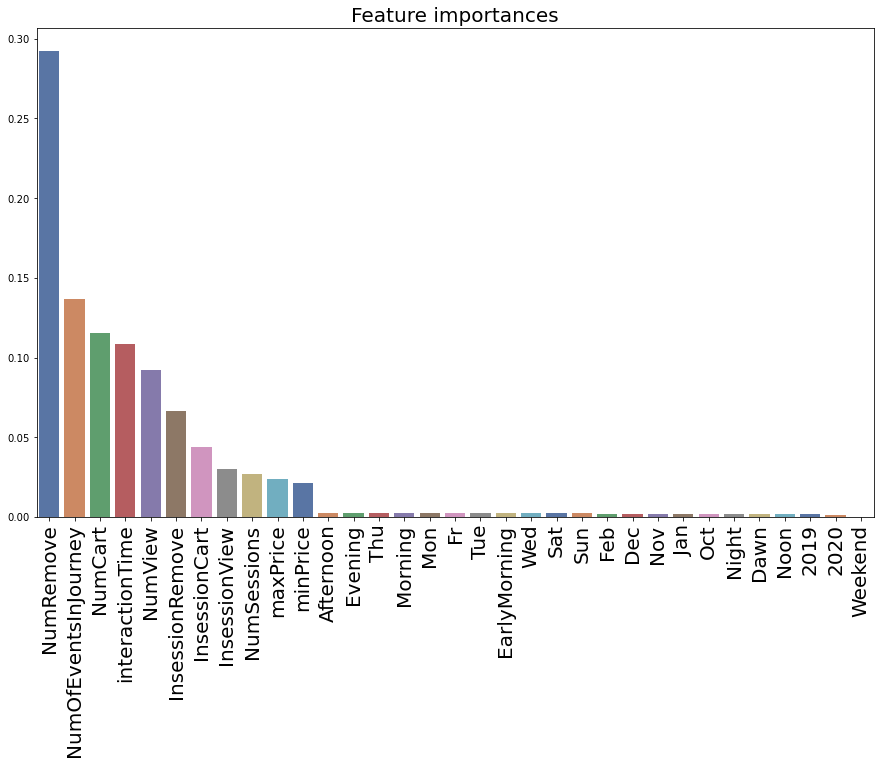

In [19]:
indices = np.argsort(importances)[::-1] 
colname = XData.columns[indices]
plt.figure(figsize=(15,9))
plt.title("Feature importances",size=20)
sn.barplot(x=colname, y=importances[indices],palette="deep")
plt.xticks(rotation=90,size=20)
plt.show()

In [20]:
# Method 2: Feature Ranking with feature_selection (fs) library
kb = fs.SelectKBest(k=X_train.shape[1])
kb.fit(X_train, y_train)
names = XData.columns.values[kb.get_support()]
scores = kb.scores_[kb.get_support()]
names_scores = list(zip(names, scores))

/Users/alejandro.robles/opt/anaconda3/envs/fbai-mlops-assignments/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/alejandro.robles/opt/anaconda3/envs/fbai-mlops-assignments/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [21]:
fScoreDF = pd.DataFrame(data = names_scores, columns=['Feat_names','F_Scores'])
fScoreDF_sorted = fScoreDF.sort_values(['F_Scores','Feat_names'], ascending =[False, True])

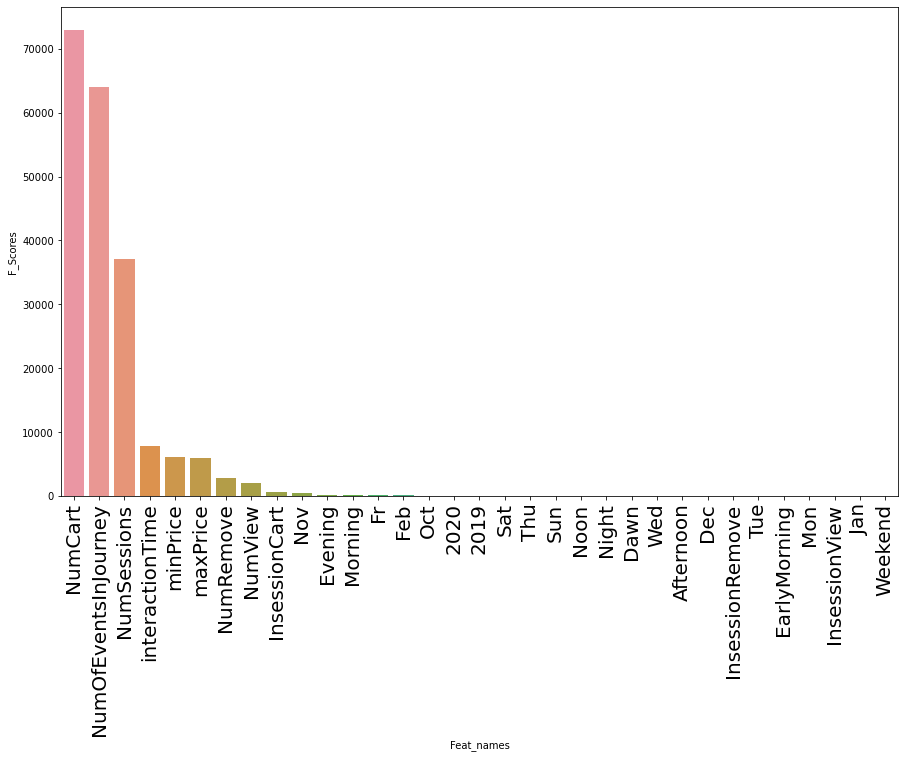

In [22]:
plt.figure(figsize=(15,9))
sn.barplot(x= "Feat_names", y="F_Scores",data=fScoreDF_sorted)
plt.xticks(rotation=90,size=20)
plt.show()

## Thus, we observe that the temporal features (time, day, year etc) have significantly less importance than the other features. Thus, we reduce data dimensionality by discarding the temporal features!

In [23]:
# Write code to extract non-temporal features only for the X_train and X_test.
# X_train_1=X_train.drop(['Weekend', 'Fr', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', '2019',
#        '2020', 'Jan', 'Feb', 'Oct', 'Nov', 'Dec', 'Afternoon', 'Dawn',
#        'EarlyMorning', 'Evening', 'Morning', 'Night', 'Noon'], axis=1)
# X_test_1=X_test.drop(['Weekend', 'Fr', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', '2019',
#        '2020', 'Jan', 'Feb', 'Oct', 'Nov', 'Dec', 'Afternoon', 'Dawn',
#        'EarlyMorning', 'Evening', 'Morning', 'Night', 'Noon'], axis=1)
##############################################################33

In [24]:
cols = ['Weekend', 'Fr', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', '2019',
       '2020', 'Jan', 'Feb', 'Oct', 'Nov', 'Dec', 'Afternoon', 'Dawn',
       'EarlyMorning', 'Evening', 'Morning', 'Night', 'Noon']

In [25]:
X_train_1 = pd.DataFrame(X_train, columns=XData.columns).drop(cols, axis=1).to_numpy()
X_test_1 = pd.DataFrame(X_test, columns=XData.columns).drop(cols, axis=1).to_numpy()

In [26]:
# Next lets look at the data distribution
# Write code to print and view (histogram) the fraction of purchases (label 1) vs non-purchases (label 0) in X_train and X_test
print("Fraction of Purchases in train data=", y_train.value_counts() / y_train.shape[0])
print("Fraction of Purchases in test data=", y_test.value_counts() / y_test.shape[0])



Fraction of Purchases in train data= 0    0.879768
1    0.120232
Name: Purchase, dtype: float64
Fraction of Purchases in test data= 0    0.879109
1    0.120891
Name: Purchase, dtype: float64


<AxesSubplot:ylabel='Frequency'>

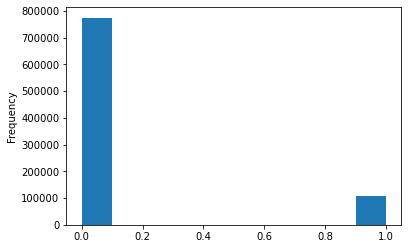

In [27]:
(y_train).plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

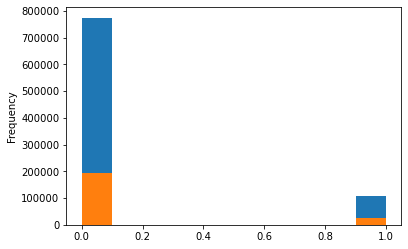

In [28]:
ax = y_train.plot(kind='hist')
y_test.plot(ax=ax, kind='hist')

# Task 2 [Instructor Led]: Build a classifier hyper-parameterization pipeline with Sagemaker for complete dataset.
We will see one method together, please run the other one yourself in Breakout sessions.

## Step 1:  Here, we convert the processed training data to protobuf and write to S3 for linear-learner in Sagemaker. Ensure the "New bucket name" is accurate in the cell underneath.

In [27]:
bucket_new='alejandro-sagemaker-bucket-2'# Add the name of your data bucket here (NEW BUCKET NAME)
prefix = "sagemaker/ecommerce"  # replace this with your own prefix
s3_train_key = "{}/train/recordio-pb-data".format(prefix)
s3_train_path = os.path.join("s3://", bucket_new, s3_train_key)
vectors = np.array([t.tolist() for t in X_train_1]).astype("float32")
labels = np.array(y_train).astype("float32")
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, vectors, labels)
buf.seek(0)
boto3.resource("s3").Bucket(bucket_new).Object(s3_train_key).upload_fileobj(buf)


In [43]:
# pip install -U sagemaker

     |████████████████████████████████| 452 kB 4.9 MB/s eta 0:00:01
  Created wheel for sagemaker: filename=sagemaker-2.69.0-py2.py3-none-any.whl size=625707 sha256=ece7c9ad97cfc84e0d7a775d0dc3bd99934707af69979639c3f5f3c4c415bff6
  Stored in directory: /home/ec2-user/.cache/pip/wheels/f4/2c/36/3ab4164cdc3413eb82504df7915934940baa5aa7fac923dc0f
Successfully built sagemaker
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.66.0
    Uninstalling sagemaker-2.66.0:
      Successfully uninstalled sagemaker-2.66.0
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


We will wrap the model training setup in a convenience function that takes in the S3 location of the training data, the model hyperparameters that define our training job, and the S3 output path for model artifacts. Inside the function, we'll hardcode the algorithm container, the number and type of EC2 instances to train on, and the input and output data formats.

In [28]:
from sagemaker.amazon.amazon_estimator import get_image_uri

def predictor_from_hyperparams(s3_train_data, hyperparams, output_path):
    """
    Create an Estimator from the given hyperparams, fit to training data, and return a deployed predictor
    """
    # specify algorithm containers and instantiate an Estimator with given hyperparams
    container = get_image_uri(boto3.Session().region_name, "linear-learner")
#     container = get_image_uri("us-east-2.amazonaws.com", "linear-learner")
    

    linear = sagemaker.estimator.Estimator(
        container,
        role,
        instance_count=1,
        instance_type="ml.m4.xlarge",
        output_path=output_path,
        sagemaker_session=sagemaker.Session(),
    )
    linear.set_hyperparameters(**hyperparams)
    # train model
    linear.fit({"train": s3_train_data})
    # deploy a predictor
    linear_predictor = linear.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")
    #linear_predictor.content_type = "csv"
    linear_predictor.serializer = csv_serializer
    linear_predictor.deserializer = json_deserializer
    return linear_predictor

In [29]:
boto3.Session().region_name

'us-east-2'

And add another convenience function for setting up a hosting endpoint, making predictions, and evaluating the model. To make predictions, we need to set up a model hosting endpoint. Then we feed test features to the endpoint and receive predicted test labels. To evaluate the models we create in this exercise, we'll capture predicted test labels and compare them to actuals using some common binary classification metrics.

In [30]:
def evaluate(linear_predictor, test_features, test_labels, model_name, verbose=True):
    """
    Evaluate a model on a test set given the prediction endpoint.  Return binary classification metrics.
    """
    # split the test data set into 100 batches and evaluate using prediction endpoint
    prediction_batches = [
        linear_predictor.predict(batch)["predictions"]
        for batch in np.array_split(test_features, 100)
    ]
    # parse raw predictions json to exctract predicted label
    test_preds = np.concatenate(
        [np.array([x["predicted_label"] for x in batch]) for batch in prediction_batches]
    )

    # calculate true positives, false positives, true negatives, false negatives
    tp = np.logical_and(test_labels, test_preds).sum()
    fp = np.logical_and(1 - test_labels, test_preds).sum()
    tn = np.logical_and(1 - test_labels, 1 - test_preds).sum()
    fn = np.logical_and(test_labels, 1 - test_preds).sum()

    # calculate binary classification metrics
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    f1 = 2 * precision * recall / (precision + recall)

    if verbose:
        print(pd.crosstab(test_labels, test_preds, rownames=["actuals"], colnames=["predictions"]))
        print("\n{:<11} {:.3f}".format("Recall:", recall))
        print("{:<11} {:.3f}".format("Precision:", precision))
        print("{:<11} {:.3f}".format("Accuracy:", accuracy))
        print("{:<11} {:.3f}".format("F1:", f1))

    return {
        "TP": tp,
        "FP": fp,
        "FN": fn,
        "TN": tn,
        "Precision": precision,
        "Recall": recall,
        "Accuracy": accuracy,
        "F1": f1,
        "Model": model_name,
    }

And finally we'll add a convenience function to delete prediction endpoints after we're done with them:

In [31]:
def delete_endpoint(predictor):
    try:
        boto3.client("sagemaker").delete_endpoint(EndpointName=predictor.endpoint)
        print("Deleted {}".format(predictor.endpoint))
    except:
        print("Already deleted: {}".format(predictor.endpoint))

Let's begin by training a binary classifier model with the linear learner default settings. Note that we're setting the number of epochs to 10. Also, notice that the the function above has an EARLY STOPPING CRITERIA set to when Recall reaches 0.7. See more on Early Stopping Criteria in https://github.com/aws/amazon-sagemaker-examples/blob/master/scientific_details_of_algorithms/linear_learner_class_weights_loss_functions/linear_learner_class_weights_loss_functions.ipynb

With early stopping, we don't have to worry about setting the number of epochs too high. Linear learner will stop training automatically after the model has converged.

## Step 2: Initiate hyperpramatereization using the pipeline below.
### For each Breakout group members should consider using either one of the celles below (labelled OPTION 1, OPTION 2) and then sharing results to see which are the best. Running both can take a LONG time. So for timely completion please selection either OPTION 1 or 2.

In [ ]:
# [OPTION 1]: Training a binary classifier (Logistic Regression) with automated threshold tuning

autothresh_hyperparams = {
    "feature_dim": 12,
    "predictor_type": "binary_classifier",
    "binary_classifier_model_selection_criteria": "precision_at_target_recall",
    "target_recall": 0.8,
    "epochs": 10,
}
autothresh_output_path = "s3://{}/{}/autothresh/output".format(bucket_new, prefix)
autothresh_predictor = predictor_from_hyperparams(
    s3_train_path, autothresh_hyperparams, autothresh_output_path
)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-11-13 22:55:20 Starting - Starting the training job...
2021-11-13 22:55:43 Starting - Launching requested ML instancesProfilerReport-1636844120: InProgress
......
2021-11-13 22:56:43 Starting - Preparing the instances for training..

In [ ]:
# Evaluation for OPTION 1
predictors = {
    "Logistic with auto threshold": autothresh_predictor,
         
}
metrics = {
    key: evaluate(predictor, X_test_1, y_test, key, False)
    for key, predictor in predictors.items()
}
pd.set_option("display.float_format", lambda x: "%.3f" % x)
display(
    pd.DataFrame(list(metrics.values())).loc[:, ["Model", "Recall", "Precision", "Accuracy", "F1"]]
)

## Option 2 starts below

In [45]:
# [OPTION 2]: Training a binary classifier with hinge loss, balanced class weights, and automated threshold tuning
svm_balanced_hyperparams = {
    "feature_dim": 12,
    "predictor_type": "binary_classifier",
    "loss": "hinge_loss",
    "binary_classifier_model_selection_criteria": "precision_at_target_recall",
    "target_recall": 0.8,
    "positive_example_weight_mult": "balanced",
    "epochs": 10,
}
svm_balanced_output_path = "s3://{}/{}/svm_balanced/output".format(bucket, prefix)
svm_balanced_predictor = predictor_from_hyperparams(
    s3_train_path, svm_balanced_hyperparams, svm_balanced_output_path
)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-06-23 21:52:02 Starting - Starting the training job...
2021-06-23 21:52:25 Starting - Launching requested ML instancesProfilerReport-1624485121: InProgress
.........
2021-06-23 21:53:47 Starting - Preparing the instances for training.........
2021-06-23 21:55:27 Downloading - Downloading input data...
2021-06-23 21:55:58 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[06/23/2021 21:56:02 INFO 139915776591680] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'ini

In [46]:
# Evaluation for OPTION 2
predictors = {
    "Hinge with class weights": svm_balanced_predictor,
    
}
metrics = {
    key: evaluate(predictor, X_test_1, y_test, key, False)
    for key, predictor in predictors.items()
}
pd.set_option("display.float_format", lambda x: "%.3f" % x)
display(
    pd.DataFrame(list(metrics.values())).loc[:, ["Model", "Recall", "Precision", "Accuracy", "F1"]]
)

The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The csv_seri

,Model,Recall,Precision,Accuracy,F1
0,Hinge with class weights,0.811,0.442,0.854,0.572


# Task 3: Data Clustering
## The Data Engineering team further tells you that 5 types of user clusters exist. Can you categorize each user to a separate cluster?
Use kmeans here https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [47]:
# Next cluster using k-means on the 3 dimensional data
from sklearn.cluster import KMeans
#Write code to perform clustering, print shape of cluster centers
#######################################

(5, 12)

In [48]:
# Write code to use kmeans to predict cluster labels for each cample in X_train_1 and X_test_1
y_train_CID=None
y_test_CID=None


In [49]:
classes=['0','1','2','3','4'] #Since we know there are 5 clusters

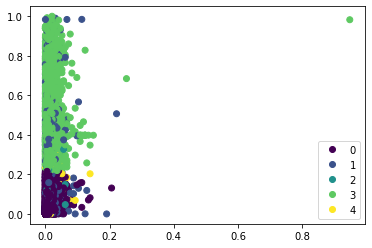

In [50]:
#scatter plot with original data
scatter=plt.scatter(X_test_1[:,0], X_test_1[:,1], c=y_test_CID, cmap='viridis')
plt.legend(handles=scatter.legend_elements()[0], labels=classes)

## Next, lets find the composition of each cluster in terms of teh following 2 metrics.
For further information on these metrics see the paper https://arxiv.org/pdf/2102.01625.pdf
```
Representaion (Rep)=#samples in a cluster/total number of samples.
Purchase Ratio (PuR)=#purchases/number of samples in a cluster.
```

In [51]:
#Write code to print the Rep and PuR for each of the 5 clusters
#########################################################

For cluster 0 Rep= 78.35 PuR= 12.09
For cluster 1 Rep= 14.39 PuR= 12.94
For cluster 2 Rep= 0.89 PuR= 1.4
For cluster 3 Rep= 2.59 PuR= 23.53
For cluster 4 Rep= 3.79 PuR= 2.17


## Our findings are as follows (Your Label IDs may vary):
1. Cluster label 0 represents the majority customers with similar purchase ratio as complete data set. This cluster is biasing major class. 
2. Cluster label 3 has double purchase ratio than complete data set but very small representation. 
3. Cluster 2 and 4 represent rarely purchasing/non-purchasing customers

# Task 4: Classification per cluster
## Resuing the code from Task 2, Report the best classification performances for the cluster variants
### Find the best classification performances for cluster with "highest purchase ratio" and the cluster with "low purchase ratio"
### It is suggested that students divide work in the breakout session to complete analysis of both clusters.

### Step 1: Subsample X_train,y_train, X_test, y_test per cluster followed by classification on the data

In [ ]:
locs_2=np.where(y_train_CID==2)
X_train_2=X_train[locs_2[0],:]
y_train_2=np.take(y_train,locs_2[0])
locs_2_t=np.where(y_test_CID==2)
X_test_2=X_test[locs_2_t[0],:]
y_test_2=np.take(y_test,locs_2_t[0])

In [ ]:
s3_train_key = "{}/train/cluster2/recordio-pb-data".format(prefix)
s3_train_path = os.path.join("s3://", bucket_new, s3_train_key)
vectors = np.array([t.tolist() for t in X_train_2]).astype("float32")
labels = np.array(y_train_2).astype("float32")
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, vectors, labels)
buf.seek(0)
boto3.resource("s3").Bucket(bucket_new).Object(s3_train_key).upload_fileobj(buf)

In [ ]:
autothresh_hyperparams_2 = #Enter more code here

In [ ]:
predictors = #Enter More code here

## Step 2: Repeat the steps for cluster 3

In [ ]:
#Finally, clean up all the predictors
for predictor in [
    autothresh_predictor,
    svm_balanced_predictor,
]:
    delete_endpoint(predictor)

# Summary and Discussion
## 1. Now we see that separately targeting behavioral clusters can aid targeted campaign design. What other features do you think should be monitored  to identify differences between clusters?
## 2. How can you extend the learning from this assignment to other use cases. Discuss examples!